**MIT Engenharia de Dados: Big Data**

---

**Disciplina: Infraestrutura Cassandra**


***Explique, com suas palavras, as diferenças entre bases de dados SQL e NoSQL, apresentando exemplos de uso para cada uma delas.***


A diferença entre o SQL e o NoSQL reside principalmente na modelagem dos dados ou, ainda, no formato de dados aceito pelo sistema gerenciador. Enquanto o SQL possui por definição o schema pré-definido e tabular para armazenamento de dados, o NoSQL abre novas possibilidades com esquemas não rigidos e não tabulares. Um exemplo: se quiser avaliar a capacidade de times de futebol, eu teria que analisar dados de atacantes e goleiros, os dados de ‘chutes para gol’ e ‘defesas dificeis’ iriam compor a minha base de análise. Em um banco SQL, como para a grande maioria dos jogadores o campo ‘defesas dificeis’ seria inconsistente com a análise da performance, ele provavelmente viria nulo ou zerado. Isso porque o campo faria parte do schema pré-definido que é o mesmo para todas as observações. Esse é um problema que poderia ser solucionado pelo schema não-relacional, já que este permite a inclusão de campos com schema a nível de chave. Esse é um exemplo da capacidade do Cassandra, que como banco de família de colunas, consegue definir as colunas para cada chave única na sua declaração. Com isso, goleiros teriam a coluna ‘defesas dificeis’ enquanto atacantes não, e isso seria definido no momento da inclusão do dado na tabela.



Em um período de copa do mundo, poucos assuntos rendem mais interesse que o futebol. Como uma robusta rede de entreterimento, o futebol possui diversas midias pelas quais os seus fãs podem consumir conteúdo e de onde a industria pode gerar receita. O Jogo Fifa da Eletronic Arts tem hoje um papel central nesse segundo foco. A venda de jogadores para membros do game rende em média 4 bilhões de dólares por ano e em 2022 pode não ser diferente. Nosso intuito nessa análise será responder algumas perguntas utilizando o Cassandra como storage principal dos dados. O objetivo será criar modelagens de dados que respondam perguntas que podem facilitar a análise de compradores no jogo Fifa 22. Para tanto usaremos o dataset de jogadores no Game disponibilizado no Kaggle no link:

 https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset. 
 
 O database Cassandra será criado através do DataStax e sua versão do Cassandra, o AstraDB. O intuito é que a modelagem dos dados consiga responder rapidamente 2 perguntas:

1.   Como o jogador está em relação ao seu próprio passado? Ele está vivendo o seu auge ou já em um declínio técnico?
2.   País a país, quais são os melhores jogadores nesse ano de 2022 e nos anos anteriores?

Além dessas duas perguntas, buscaremos também entender se é possível prever a partir da base o valor de mercado de um jogador. Como esse valor é base para as transações feitas dentro do jogo Fifa 22, isso significaria o entendimento das features que compõem o preço a ser pago pelos jogadores.

Afim de explorarmos ao máximo as funcionalidades de um banco NoSql, o inicialmente faremos um tratamento na linguagem Python nas bases importadas. Esse tratamento tem como objetivo unificar as bases por anos e separar os dados de goleiros dos jogadores de outras posições. Como os goleiros possuem competências específicas que possuem valor nulo nos demais jogadores, e vice-versa, essa separação visa reduzir o volume de armazenamento nulo.

In [ ]:
# Import de bibliotecas base que serão utilizadas ao longo do Notebook
import pandas as pd
import json
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files



In [ ]:
# Import das bases e adição de uma coluna com o ano em questão

m_16 = pd.read_csv('/content/players_16.csv', sep=',')
m_16['year'] = 2016
m_17 = pd.read_csv('/content/players_17.csv', sep=',')
m_17['year'] = 2017
m_18 = pd.read_csv('/content/players_18.csv', sep=',')
m_18['year'] = 2018
m_19 = pd.read_csv('/content/players_19.csv', sep=',')
m_19['year'] = 2019
m_20 = pd.read_csv('/content/players_20.csv', sep=',')
m_20['year'] = 2020
m_21 = pd.read_csv('/content/players_21.csv', sep=',')
m_21['year'] = 2021
m_22 = pd.read_csv('/content/players_22.csv', sep=',')
m_22['year'] = 2022
f_16 = pd.read_csv('/content/female_players_16.csv', sep=',')
f_16['year'] = 2016
f_17 = pd.read_csv('/content/female_players_17.csv', sep=',')
f_17['year'] = 2017
f_18 = pd.read_csv('/content/female_players_18.csv', sep=',')
f_18['year'] = 2018
f_19 = pd.read_csv('/content/female_players_19.csv', sep=',')
f_19['year'] = 2019
f_20 = pd.read_csv('/content/female_players_20.csv', sep=',')
f_20['year'] = 2020
f_21 = pd.read_csv('/content/female_players_22.csv', sep=',')
f_21['year'] = 2021
f_22 = pd.read_csv('/content/female_players_22.csv', sep=',')
f_22['year'] = 2022

In [ ]:
# União de todas as tabelas de forma a criar uma única fonte de informação com todos os dados
frames = [m_16, m_17, m_18, m_19, m_20, m_21, m_22, f_16, f_17, f_18, f_19, f_20, f_21, f_22]
all_players = pd.concat(frames, sort=False)

In [ ]:
# Separação dos dados em dois dataframes, os de goleiros e os de não goleiros
goalkeepers_players = all_players.query('club_position == "GK"')
other_players = all_players.query('club_position != "GK"')

In [ ]:
# A partir dos dois dataframes, selecionam-se apenas as colunas com dados válidos para cada posição

goalkeepers_columns = ['sofifa_id','year','short_name','overall','value_eur','age','club_team_id','club_name','club_position','nationality_id','nationality_name','attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes','goalkeeping_speed']
other_players_columns = ['sofifa_id','year','short_name','overall','value_eur','age','club_team_id','club_name','club_position','nationality_id','nationality_name','pace','shooting','passing','dribbling','defending','physic','attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle'] 
goalkeepers_df = goalkeepers_players[goalkeepers_columns]
other_players_df =  other_players[other_players_columns]

In [ ]:
# Serão criados agora dois arquivos CSV que posteriormente são exportados para serem incluídos no Database Cassandra

goalkeepers_df.to_csv('goalkeepers_df.csv', index=False)
other_players_df.to_csv('other_players.csv', index=False)

files.download("goalkeepers_df.csv")
files.download("other_players.csv")


A partir da página do DataStax https://astra.datastax.com/ é possível criar um banco de dados de formato família de colunas, e é a partir dessa página que faremos a modelagem de duas tabelas a primeira visa responder jogador a jogador em que ano foi o seu melhor ano. Abaixo é possível ver a modelagem da tabela feito através da UI do aplicativo e a query que visualiza essa informação. A modelagem foi feita tendo a partition key como o código único de cada jogador e as clustering keys sendo o overall que é a média de todas as habilidades consideradas no jogo e o ano.

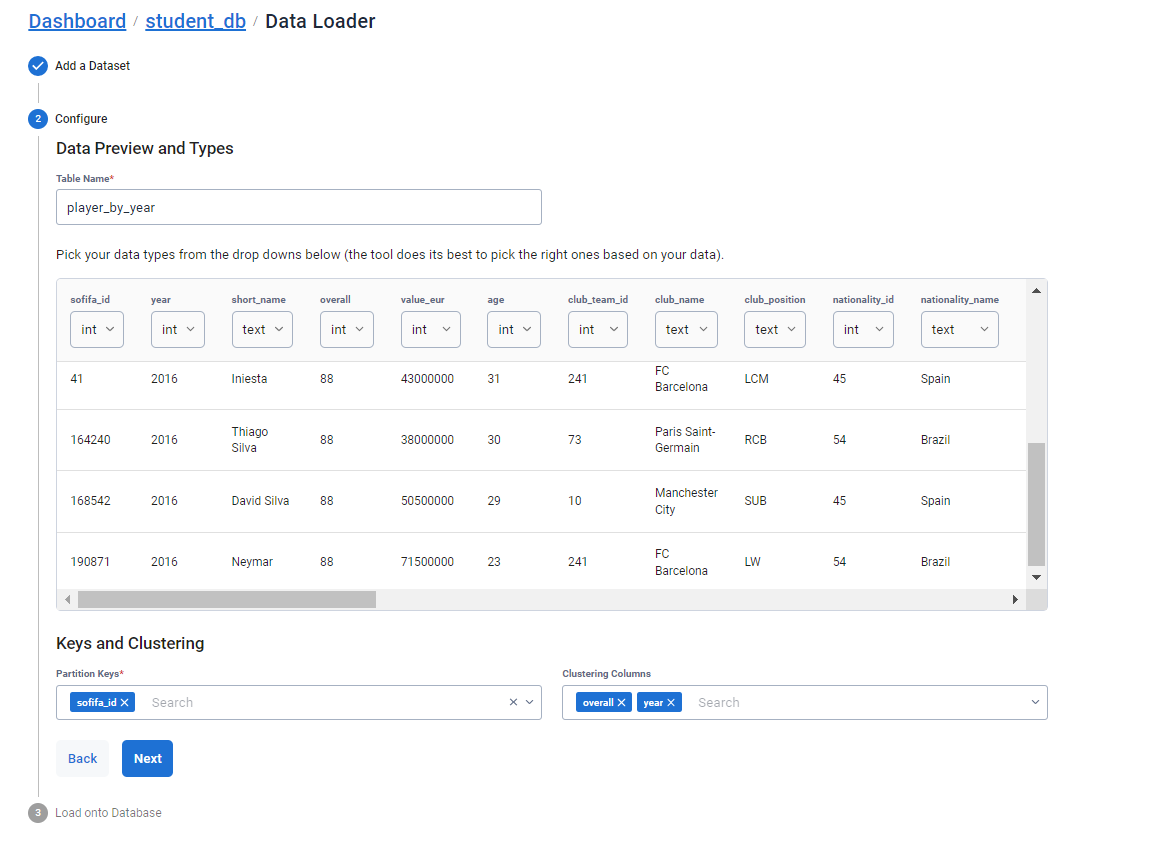

Abaixo é possível verificar a query feita para Lionel Messi que demonstra que apesar de não estar no seu melhor ano no jogo, a queda é muito pequena em comparação aos últimos 6 anos.

player_by_year_2.png


O mesmo será feito para responder a pergunta de quem é o melhor jogador por país a cada ano. A diferença estará nas primary keys que utilizaresmos. Nesse caso, a nacionalidade e ano são as partitions keys e overall e sofifa_id serão as clustering keys. Além disso, para a inclusão dos goleiros, foi feita também uma alter table incluindo as novas colunas.

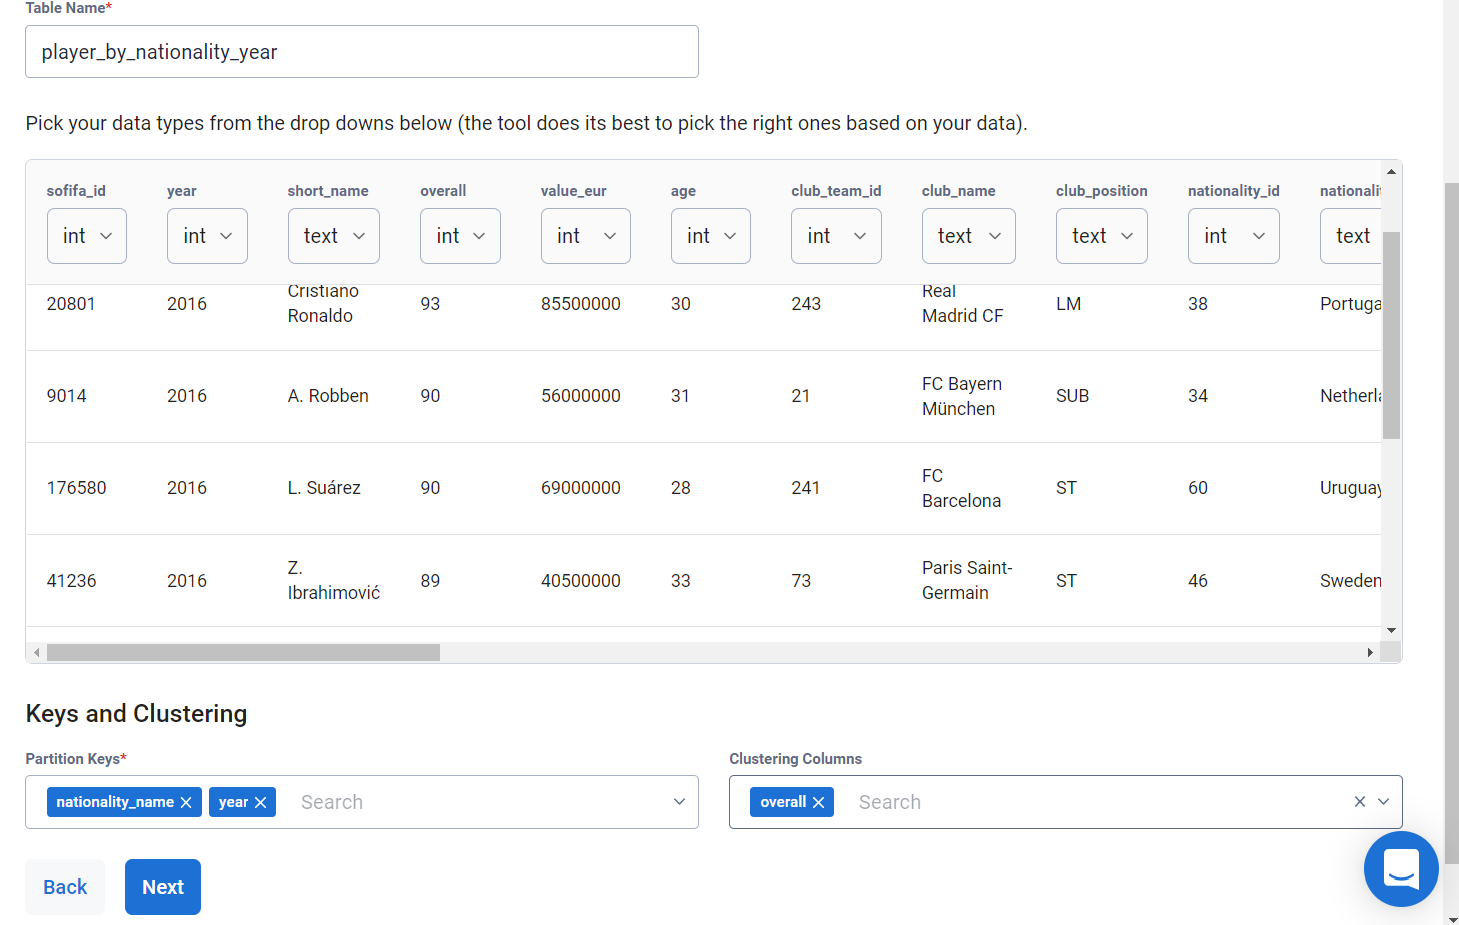

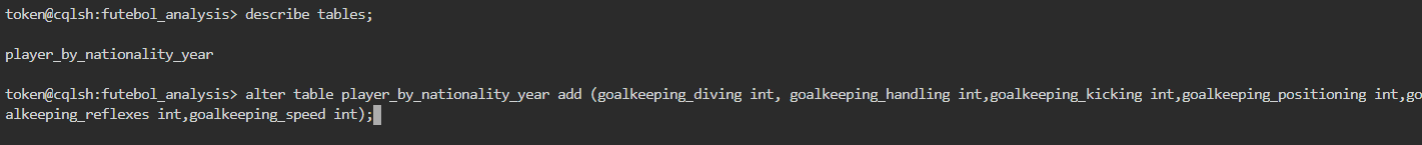

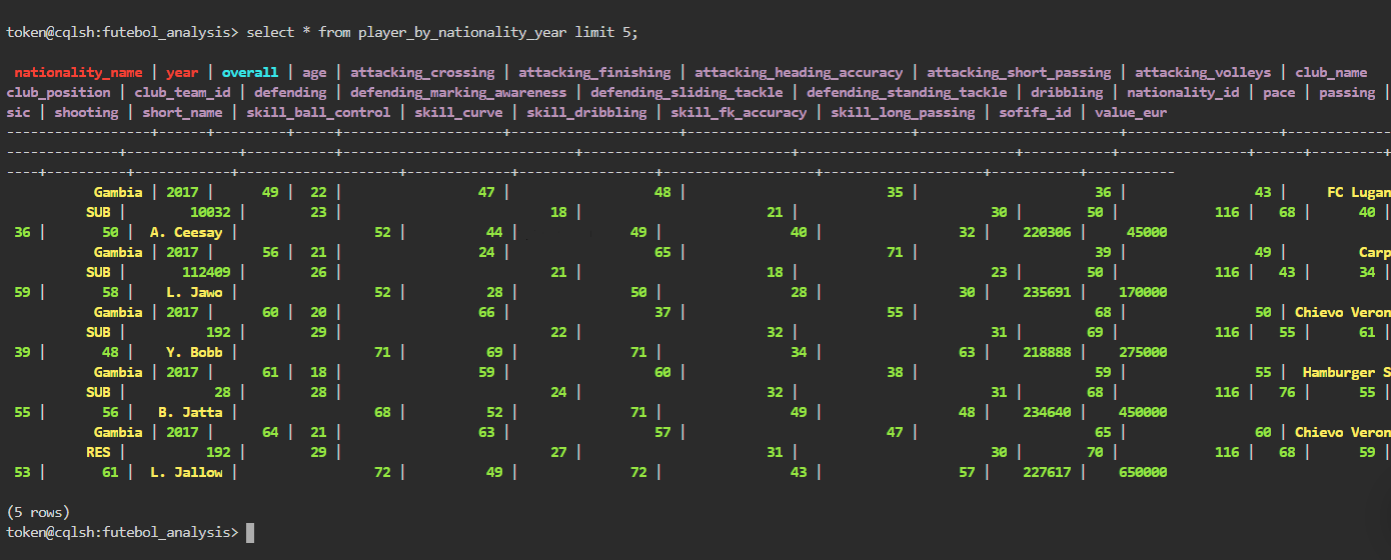

Abaixo é feita a instalação do driver cassandra que permitirá a conexão dos dados. Para tanto foi necessário baixar o bundle de conexão segura do DataStax e criar a conexão ao Keyspace no qual faremos as queries. O resultado será um json que converteremos em um pandas dataframe. O objetivo é criar um modelo de machine learning que consiga prever o valor em euros de cada jogador.

---



In [1]:
pip install cassandra-driver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.8 MB 8.7 MB/s 


In [ ]:
import cassandra
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from cassandra.query import dict_factory

In [3]:
 # Print da versão do Cassandra
 print (cassandra.__version__)

3.25.0


In [4]:
 # Autenticação e criação de uma sessão no Cassandra.

cloud_config= {
         'secure_connect_bundle': '/content/secure-connect-student-db.zip'
}
auth_provider = PlainTextAuthProvider('ewnaKNlAXiKMksmjsdFZmeBp', 'W-1BHrjc_.X9J1wOGcZH-.eG9kOmtgEkGj1.OvIsekUA4u5rCBz_AvN11hOoDjA.8b+HXJEa,Ef4rzpFd7oTIcnXGgBXCP5rrHj6Bk3,4nuJx5mv1X9hLmPc4w9a.AK3')
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
      print(row[0])
else:
      print("An error occurred.")

ERROR:cassandra.connection:Closing connection <LibevConnection(140492898423760) f192d38c-8fea-440a-8651-4db3e7fa1606-us-east1.db.astra.datastax.com:29042:475c4b73-d944-4e5c-8824-4adff0141231> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


4.0.0.6816


In [6]:
 # Após o teste de conexão, é feita uma nova conexão diretamente ao Keyspace onde estão os dados. 

session = cluster.connect('futebol_analysis')
session.row_factory = dict_factory
rows = session.execute("SELECT * FROM player_by_nation_year")
print(rows[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  """


{'nationality_name': 'Gambia', 'year': 2017, 'overall': 49, 'sofifa_id': 220306, 'age': 22, 'attacking_crossing': 47, 'attacking_finishing': 48, 'attacking_heading_accuracy': 35, 'attacking_short_passing': 36, 'attacking_volleys': 43, 'club_name': 'FC Lugano', 'club_position': 'SUB', 'club_team_id': 10032, 'defending': 23, 'defending_marking_awareness': 18, 'defending_sliding_tackle': 21, 'defending_standing_tackle': 30, 'dribbling': 50, 'goalkeeping_diving': None, 'goalkeeping_handling': None, 'goalkeeping_kicking': None, 'goalkeeping_positioning': None, 'goalkeeping_reflexes': None, 'goalkeeping_speed': None, 'nationality_id': 116, 'pace': 68, 'passing': 40, 'physic': 36, 'shooting': 50, 'short_name': 'A. Ceesay', 'skill_ball_control': 52, 'skill_curve': 44, 'skill_dribbling': 49, 'skill_fk_accuracy': 40, 'skill_long_passing': 32, 'value_eur': 45000}


In [7]:
 # Afim de converter os dados em um formato de dataframe, é feito um laço de repetição 
 # para que cada linha seja adicionada a uma lista de json's.

i = 0
total = []
while i < 128214:
  result = rows[i]
  total.append(result)
  i = i + 1

data = {'players': total}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  after removing the cwd from sys.path.


In [80]:
 # Os jsons adicionados em uma lista são normalizados em um dataframe pandas

df_players = json_normalize(data['players']) 


In [81]:
# Para termos um valor em escala compreensível, os valores serão divididos por 1 milhão e uma nova coluna será criada

df_players['value_in_milions'] = df_players['value_eur']/1000000

In [82]:
# Na análise da coluna é possível entender que a média e a media não estão na mesma escala de grandeza, o que é um indicador de outliers. 
# No entanto, como a ideia é justamente prever esses outliers afim de facilitar as transações, essas informações serão mantidas.

df_players['value_in_milions'].describe()

count    124430.000000
mean          2.421805
std           6.035621
min           0.002000
25%           0.350000
50%           0.750000
75%           1.900000
max         194.000000
Name: value_in_milions, dtype: float64

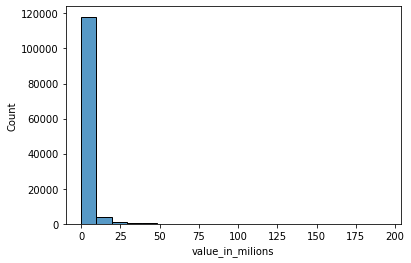

In [83]:
# O gráfico demonstra que de fato a maioria dos dados está mais próxima do valor entre 0 e 1 milhão.

sns.histplot(df_players['value_in_milions'], bins = 20)

In [25]:
# A coninuidade do notebook será feita em spark através da biblioteca pyspark. Para isso, faremos o import da biblioteca

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 42.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=6dcd6e8c2144632e1f65766df16e6f155b12809c84503763383d857ee71b16dd
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [46]:
from pyspark import SparkConf, SparkContext
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression 
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan, when, count

In [28]:
# Aqui é aberta uma sessão do Spark

spark  = SparkSession.builder.appName('Spark').getOrCreate()

In [84]:
# E o dataframe criado pelo pandas é convertido para um dataframe spark

df_players_spark = spark.createDataFrame(df_players)

In [86]:
# Em uma análise inicial, entendemos quais são os campos nulos. Considerando que a variavel alvo possui valores nulos. Exluirã-se as linhas 
# com valores nulos.

df_players_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_players.columns]).show()

+----------------+----+-------+---------+---+------------------+-------------------+--------------------------+-----------------------+-----------------+---------+-------------+------------+---------+---------------------------+------------------------+-------------------------+---------+------------------+--------------------+-------------------+-----------------------+--------------------+-----------------+--------------+-----+-------+------+--------+----------+------------------+-----------+---------------+-----------------+------------------+---------+----------------+
|nationality_name|year|overall|sofifa_id|age|attacking_crossing|attacking_finishing|attacking_heading_accuracy|attacking_short_passing|attacking_volleys|club_name|club_position|club_team_id|defending|defending_marking_awareness|defending_sliding_tackle|defending_standing_tackle|dribbling|goalkeeping_diving|goalkeeping_handling|goalkeeping_kicking|goalkeeping_positioning|goalkeeping_reflexes|goalkeeping_speed|national

In [87]:
# Antes de exluir as linhas com valores nulos, serão selecionadas as colunas numéricas com o menor número de valores nulos. 

features =  ['overall','value_in_milions','age','pace','shooting','passing','dribbling','defending','physic']
df_analysis = df_players_spark[features]
df_analysis = df_analysis.na.drop()


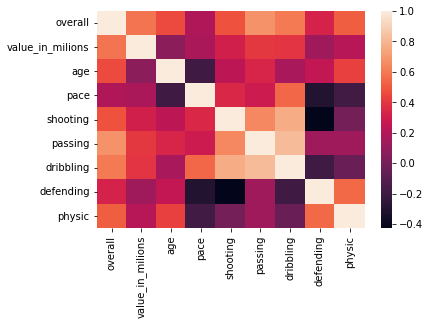

In [88]:
# Afim de entender quais variáveis são mais relevantes para o modelo, um mapa de correlação é plotado

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vector = assembler.transform(df_analysis).select("features")
matrix = Correlation.corr(df_vector, 'features', 'pearson')
corrmatrix = matrix.collect()[0][0].toArray().tolist()
df_corr = pd.DataFrame(corrmatrix, columns = features, index = features)
sns.heatmap(df_corr)

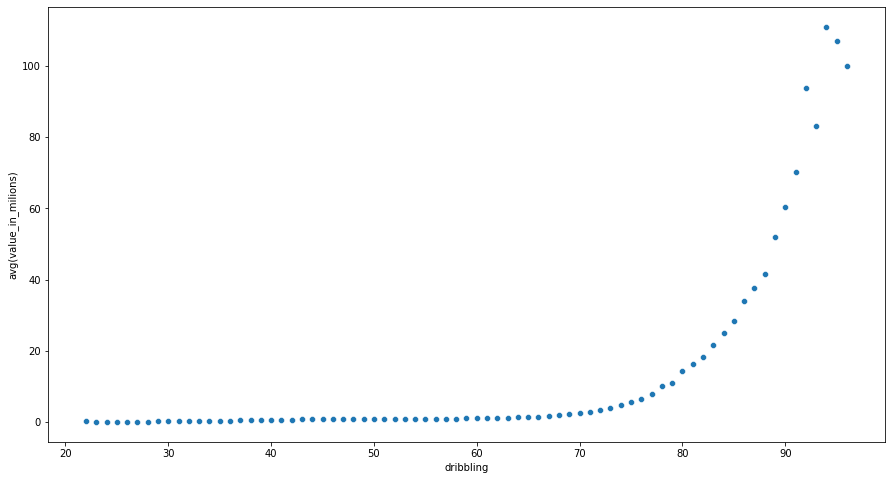

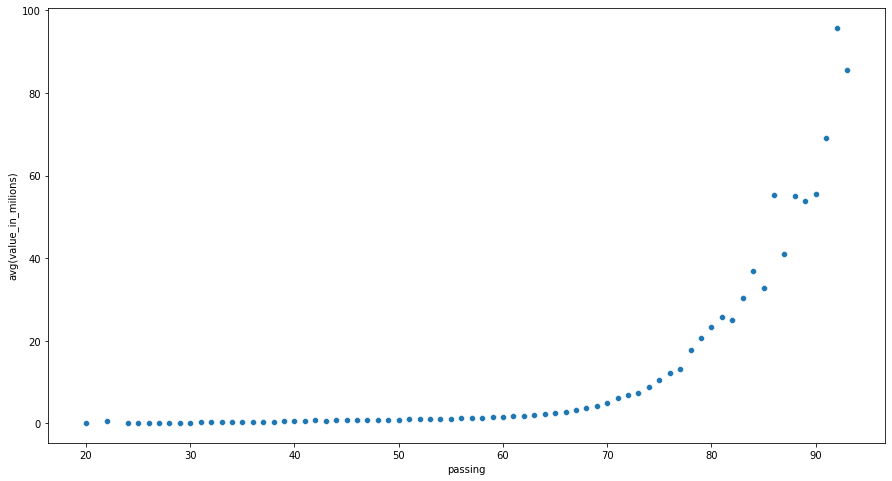

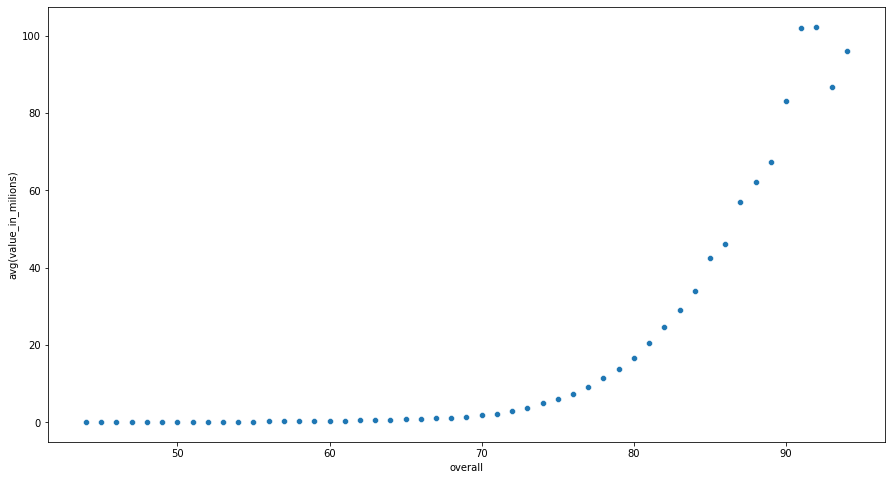

In [90]:
# Como forma de validar a correlação, um gráfico de dispersão dos valores e das principais variavies será plotado

df_grouped = df_analysis.groupby('dribbling').avg().sort('dribbling').select(['dribbling','avg(value_in_milions)'])
df_pandas = df_grouped.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_pandas['dribbling'], y = df_pandas['avg(value_in_milions)'] )

df_grouped = df_analysis.groupby('passing').avg().sort('passing').select(['passing','avg(value_in_milions)'])
df_pandas = df_grouped.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_pandas['passing'], y = df_pandas['avg(value_in_milions)'] )


df_grouped = df_analysis.groupby('overall').avg().sort('overall').select(['overall','avg(value_in_milions)'])
df_pandas = df_grouped.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_pandas['overall'], y = df_pandas['avg(value_in_milions)'] )

In [91]:
# Um dataframe com as três varíaveis selecionadas será criado e a partir dele as análises serão feitas
df_machine_learning = df_analysis.select(['dribbling','passing', 'overall', 'value_in_milions'])

In [92]:
features = VectorAssembler(inputCols = ['dribbling','passing', 'overall'], outputCol = 'features')
result = features.transform(df_machine_learning)

In [93]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withStd=True, withMean=False)
scalerModel = scaler.fit(result)
scaledOutput = scalerModel.transform(result)
scaledOutput.show(3)

+---------+-------+-------+----------------+----------------+--------------------+
|dribbling|passing|overall|value_in_milions|        features|      scaledFeatures|
+---------+-------+-------+----------------+----------------+--------------------+
|     50.0|   40.0|     49|           0.045|[50.0,40.0,49.0]|[4.8412423362901,...|
|     52.0|   48.0|     56|            0.15|[52.0,48.0,56.0]|[5.03489202974170...|
|     50.0|   34.0|     56|            0.17|[50.0,34.0,56.0]|[4.8412423362901,...|
+---------+-------+-------+----------------+----------------+--------------------+
only showing top 3 rows



In [94]:
df_final = scaledOutput.select(['value_in_milions', 'scaledFeatures'])
df_final.show(3)

+----------------+--------------------+
|value_in_milions|      scaledFeatures|
+----------------+--------------------+
|           0.045|[4.8412423362901,...|
|            0.15|[5.03489202974170...|
|            0.17|[4.8412423362901,...|
+----------------+--------------------+
only showing top 3 rows



In [95]:
# Os valores serão dividos em grupos de treino e teste e submetidos ao modelo de regressão linear

df_train, df_test = df_final.randomSplit([0.75, 0.25])
regressor = LinearRegression(featuresCol = 'scaledFeatures', labelCol = 'value_in_milions')
regressor = regressor.fit(df_train)

In [96]:
# O resultado final da predição é medido afim de garantir a precisão do modelo

prediction = regressor.evaluate(df_train)
print("O Erro Médio Quadrático é: %2f"% prediction.meanAbsoluteError)
print("O R2 do modelo é: %2f"% prediction.r2)

O Erro Médio Quadrático é: 2.472480
O R2 do modelo é: 0.351215
